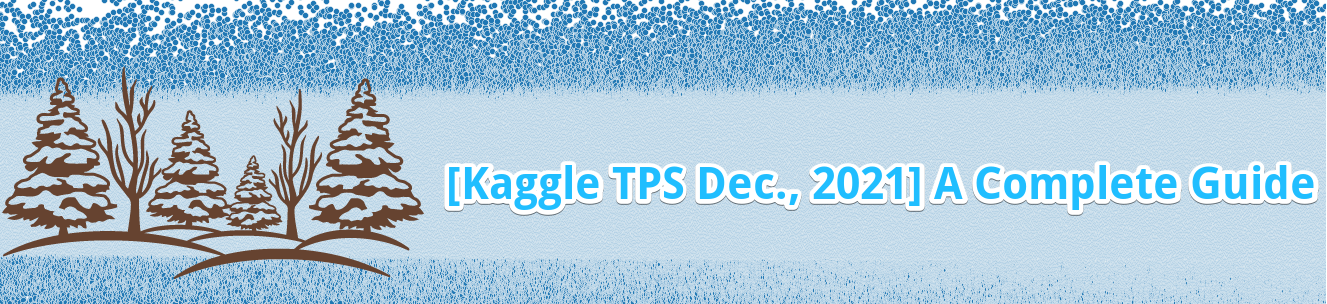

# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:180%; text-align:center; border-radius: 15px;">A Complete Guide: EDA + PyTorch Model</p>
<a id="Title"></a>

## PyTorch NN model is in the end of notebook.
## If you want to skip main part, please, click to proceed: [7. PyTorch NN Model](#7)   


>This notebook is a walk through guide for dealing with common data science competition.
>* The **objective** of this notebook is to apply step-by-step approach to solve tabular data competition.
>* The **subject** of this notebook is a multi-classification task, based on "[the synthetic dataset generated using a CTGAN on a real dataset](https://www.kaggle.com/c/tabular-playground-series-dec-2021/overview). The original dataset comes from [Forest Cover Type Prediction competition](https://www.kaggle.com/c/forest-cover-type-prediction/overview). You are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. The independent variables were then derived from data obtained from the US Geological Survey and USFS". 

## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">Table of Contents</p>
* [1. Import of Libraries](#1)
* [2. Data Visualization](#2)
* [3. Data Preprocessing](#3)
    * [3.1 Handle Missing Values](#3.1)
    * [3.2 Smoothing data / Reformating / Dropping](#3.2)
* [4. Exploratory Data Analysis](#4)
* [5. Feature engineering](#5)
* [6. Modeling](#6)
    * [6.1 k-Nearest Neighbors](#6.1)
    * [6.2 Decision Trees](#6.2)
    * [6.3 Random Forest](#6.3)
    * [6.4 Gaussian Naive Bayes](#6.4)
    * [6.5 XGB](#6.5)
    * [6.6 TabNet](#6.6)
* [7. PyTorch NN Model](#7)   
* [8. Conclusions](#8)
* [9. References](#9)

<a id='1'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">1. Import of Libraries</p>

In [ ]:
import numpy as np # Linear algebra.
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv).
import datatable as dt # Data processing, CSV file I/O (e.g. dt.fread).

import seaborn as sns # Visualization.
import matplotlib.pyplot as plt # Visualization.

# Machine Learning block.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import random
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

print(f'\n[INFO] Libraries set up has been completed.')

<a id='2'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">2. Data visualization</p>

Special thanks and reference: [SIDDHESH PUJARI](https://www.kaggle.com/siddheshpujari) and his [notebook](https://www.kaggle.com/siddheshpujari/forest-cover-eda#Dataset-Info).
>The dataset includes four wilderness areas located in the Roosevelt National Forest in northern Colorado.
>The Roosevelt National Forest is a National Forest, located in north central Colorado.
>Each observation is a 30m x 30m patch.
>
>* **Elevation** - Elevation in meters.
>* **Aspect** - Aspect in degrees azimuth.
>To study how aspect works , please refer the following website [link](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/how-aspect-works.htm) that explains how it works.
>
>* **Slope** - Slope in degrees. To study how the slope works, please refer the following website [link](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/slope.htm).
>* **Horizontal_Distance_To_Hydrology** - Horz Dist to nearest surface water features.
>* **Vertical_Distance_To_Hydrology** - Vert Dist to nearest surface water features.
>* **Horizontal_Distance_To_Roadways** - Horz Dist to nearest roadway.
>* **Hillshade_9am (0 to 255 index)** - Hillshade index at 9am, summer solstice.
>To study how aspect works , please refer the following website [link](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/hillshade.htm)
>
>* **Hillshade_Noon (0 to 255 index)** - Hillshade index at noon, summer solstice.
>* **Hillshade_3pm (0 to 255 index)** - Hillshade index at 3pm, summer solstice.
>* **Horizontal_Distance_To_Fire_Points** - Horz Dist to nearest wildfire ignition points.
>* **Wilderness_Area** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation.
>* **Soil_Type** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation.
> Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation.
>
> **Seven Types of Forest Cover**:
>* 1 - Spruce/Fir.
>* 2 - Lodgepole Pine.
>* 3 - Ponderosa Pine.
>* 4 - Cottonwood/Willow.
>* 5 - Aspen.
>* 6 - Douglas-fir.
>* 7 - Krummholz.
>
> **Let's read the data first** (I strongly recommend using 'datatable' to for faster data reading):

In [ ]:
%%time
df_train = dt.fread('../input/tabular-playground-series-dec-2021/train.csv').to_pandas()
df_test = dt.fread('../input/tabular-playground-series-dec-2021/test.csv').to_pandas()
df_sub = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')

# Datatable reads target as bool by default.
mask_bool = df_train.dtypes == bool
bool_train = df_train.dtypes[mask_bool].index
bool_test = df_test.dtypes[mask_bool].index

df_train[bool_train] = df_train[bool_train].astype('int8')
df_test[bool_train] = df_test[bool_train].astype('int8')

df_train.info(verbose=False)

> It reads the data 3x time faster than pandas. Moreover, we've been able to reduce the memory usage from 1.7 GB to 351 MB by simply downcasting some columns to int8.
>
> We do not really need **"id"** column. It will help us to reduce memory usage even more.
> Let's fix it and cast our dtypes to the smaller ones (references: [**link**](https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/294356)):


In [ ]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum()/1024**2
    numerics = ['int8', 'int16', 'int32', 'int64',
                'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        limit = abs(df[col]).max()

        for tp in numerics:
            cond1 = str(col_type)[0] == tp[0]
            if tp[0] == 'i': cond2 = limit <= np.iinfo(tp).max
            else: cond2 = limit <= np.finfo(tp).max

            if cond1 and cond2:
                df[col] = df[col].astype(tp)
                break

    end_mem = df.memory_usage().sum()/1024**2
    reduction = (start_mem - end_mem)*100/start_mem
    if verbose:
        print(f'[INFO] Mem. usage decreased to {end_mem:.2f}'
              f' MB {reduction:.2f}% reduction.')
    return df

df_train.drop(columns='Id', inplace=True)
df_test.drop(columns='Id', inplace=True)

df_train = reduce_mem_usage(df_train, verbose=True)
df_test = reduce_mem_usage(df_test, verbose=True)
df_train.head(5)

> **Now let's plot our target values**:

In [ ]:
df_target_count = df_train['Cover_Type'].value_counts()
s1 = df_target_count[:3]
s2 = pd.Series(sum(df_target_count[3:]), index=["4-5-6-7"])
s3 = s1.append(s2)

f, axes = plt.subplots(ncols=2, figsize=(15, 4))
plt.subplots_adjust(wspace=0)

outer_sizes = s3
inner_sizes = s3/4
outer_colors = ['#1B518A', '#3470A3', '#79ABC9', '#E54232']
inner_colors = ['#3470A3', '#79ABC9', '#A7C8D9']

axes[0].pie(
    outer_sizes,colors=outer_colors, 
    labels=s3.index.tolist(), 
    startangle=90,frame=True, radius=1.3, 
    explode=(.05,.05,.05,.5),
    wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
    textprops={'fontsize': 12, 'weight': 'bold'}
)

textprops = {
    'size':13, 
    'weight': 'bold', 
    'color':'white'
}

axes[0].pie(
    inner_sizes, colors=inner_colors,
    radius=1, startangle=90,
    autopct='%1.f%%',explode=(.1,.1,.1, -.5),
    pctdistance=0.8, textprops=textprops
)

center_circle = plt.Circle((0,0), .68, color='black', 
                           fc='white', linewidth=0)
axes[0].add_artist(center_circle)

x = df_target_count
y = df_target_count.index.astype(str)
sns.barplot(
    x=x, y=y, ax=axes[1],
    palette='Blues_r', orient='horizontal'
)

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    labelbottom=False
)

for i, v in enumerate(df_target_count):
    axes[1].text(v, i+0.1, str(v), color='black', 
                 fontweight='bold', fontsize=12)
 
plt.tight_layout()    
plt.show()

> Well **`df_train`** is **extremely class-imbalanced**. The classes 4, 5, 6 and 7 combined form only 1% of all observations.
>
> Assumption: If we are to choose folds for training, we are better going with Kfolds.
>
> **Next**, let's get 30000 samples and plot it:

In [ ]:
seed = 322
df_train_sample = df_train.sample(n=30000, random_state=seed)
df_test_sample = df_test.sample(n=30000, random_state=seed)

np.random.seed(seed) 
features_choice = np.random.choice(
    df_train_sample.keys()[1:-1], size=12, replace=False
)

mask = sorted(features_choice.tolist()) + ['Cover_Type']
df_sample_twelve = df_train_sample[mask]
df_sample_twelve.head(3)

In [ ]:
fig, ax = plt.subplots(nrows=12, figsize=(24, 24))

for i, feature in enumerate(sorted(features_choice)):
     sns.scatterplot(
         ax=ax[i], x=df_sample_twelve.index,
         y=feature,data=df_sample_twelve,
         hue='Cover_Type',palette='Blues_r',
         legend=True,
     )

> **Well**, now it is even more clear that we got numerical and categorical features.


<a href="#Title" role="button" aria-pressed="true" >Back to the beginning 🔙</a>

<a id='3'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">3. Data Preprocessing</p>
>**[Data preprocessing](https://en.wikipedia.org/wiki/Data_pre-processing)** can refer to manipulation or dropping of data before it is used in order to ensure or enhance performance, and is an important step in the data mining process. The phrase "garbage in, garbage out" is particularly applicable to data mining and machine learning projects.
>
>**Let's have a sanity check if we have any missing values:**

In [ ]:
missing_values_train = df_train.isna().any().sum()
missing_values_test = df_test.isna().any().sum()

print(f'\n[INFO] {missing_values_train} missing value(s) has/have been detected in the train dataset.')
print(f'[INFO] {missing_values_test} missing value(s) has/have been detected in the test dataset.')

### Missing Values, how to handle

* **Option 1: Fill NaN with Outlier or Zero.**
In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

* **Option 2: Fill NaN with Mean Value.**
Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

* **Option 3: Fill NaN with Last Value with .ffill().**
Filling NaNs with the last value could be bit better.

* **Option 4: Fill NaN with Linearly Interpolated Value with .interpolate().**
Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring values.

<a id='3.2'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">3.2 Smoothing data / Reformating / Dropping</p>

> Special thanks to **EDUARDO GUTIERREZ** and his notebook for .describe method representation and styling. [**Eduardo's notebook**](https://www.kaggle.com/eduardogutierrez/tps-nov-21-exploratory-data-analysis). 

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_train.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                     .style.background_gradient(cmap='Blues')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_test.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                     .style.background_gradient(cmap='Blues')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

> Some observations from the table above:
> * **Soil_Type7** and **Soil_Type15** are zeroes both in **`df_train`** and **`df_test`**.
>
> Let's drop it, it is not going to affect our trainig phase:

In [ ]:
df_train.drop(columns=['Soil_Type7', 'Soil_Type15'], inplace=True)
df_test.drop(columns=['Soil_Type7', 'Soil_Type15'], inplace=True)

<a href="#Title" role="button" aria-pressed="true" >Back to the beginning 🔙</a>

<a id='4'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">4. Exploratory Data Analysis</p>

> Let's take a closer look at the distribution of the features:

In [ ]:
%%time
figsize = (6*6, 6*6)
fig = plt.figure(figsize=figsize)
title = 'Probability Density Function Estimation'
for idx, col in enumerate(df_test.columns):
    ax = plt.subplot(8, 7, idx + 1)
    sns.kdeplot(
        data=df_train_sample, hue='Cover_Type', fill=True,
        x=col, palette='cividis'
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=10)

fig.supxlabel(f'\n\n{title} Train\n\n', ha='center', 
              fontweight='bold', fontsize=30)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=figsize)
for idx, col in enumerate(df_test.columns):
    ax = plt.subplot(8, 7, idx + 1)
    sns.kdeplot(
    data=df_train_sample, fill=True,
    x=col, color='#1086CE', label='Train'
    )
    sns.kdeplot(
        data=df_test_sample, fill=False,
        x=col, color='#E54232', label='Test'
    )

    ax.set_xticks([]); ax.set_xlabel(''); 
    ax.set_ylabel(''); ax.spines['right'].set_visible(False)
    ax.set_yticks([]); ax.spines['top'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=10)
    
fig.supxlabel(f'\n\n{title} Train vs Test set', ha='center', 
              fontweight='bold', fontsize=30)
       
plt.tight_layout()
plt.show()

> **We have plotted Probability Density Function estimation for each feature. What does it tell us?**
>* The features are distributed differently;
>* The data is not perfectly symmetrical. The most of the features either right or left skewed.
>* Only **Hillshade_3pm** is bell-shaped-like (e.g., Gaussian distribution);
>* Let's plot the skewness:

In [ ]:
fig = plt.figure(figsize=(15,10))
_skew = df_train[df_test.columns].skew()
sns.barplot(x=_skew, y=_skew.index, 
            lw=0, palette='Blues_r')
plt.show()

> Alright, the most of the features are skewed right. 
>
> Let's see what is the total representation of 'continuous' and 'categorical' features::

In [ ]:
cont = sum(df_train[df_test.columns].nunique() > 2)
cat = sum(df_train[df_test.columns].nunique() == 2)
df_cat = pd.DataFrame({
    'feature': ['continuous', 'categorical'],
    'total_num': [cont, cat]
})

f, axes = plt.subplots(ncols=2, figsize=(15, 4))
plt.subplots_adjust(wspace=0)

outer_sizes = df_cat.total_num
inner_sizes = outer_sizes/4
outer_colors = ['#1B518A', '#3470A3']
inner_colors = ['#3470A3', '#79ABC9']

axes[0].pie(
    outer_sizes,colors=outer_colors, 
    labels=df_cat.feature.tolist(), 
    startangle=90,frame=True, radius=1.3, 
    explode=(.05,.05),
    wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
    textprops={'fontsize': 12, 'weight': 'bold'}
)

textprops = {
    'size':13, 
    'weight': 'bold', 
    'color':'white'
}

axes[0].pie(
    inner_sizes, colors=inner_colors,
    radius=1, startangle=90,
    autopct='%1.f%%',explode=(.1,.1),
    pctdistance=0.8, textprops=textprops
)

center_circle = plt.Circle((0,0), .68, color='black', 
                           fc='white', linewidth=0)
axes[0].add_artist(center_circle)

x = df_cat.total_num
y = df_cat.feature.tolist()
sns.barplot(
    x=x, y=y, ax=axes[1],
    palette='Blues_r', orient='horizontal'
)

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    labelbottom=False
)

for i, v in enumerate(x):
    axes[1].text(v, i+0.1, str(v), color='black', 
                 fontweight='bold', fontsize=12)
 
plt.tight_layout()    
plt.show()

> Let's us take a look at features correlation matrix:

In [ ]:
corr = df_train_sample.corr()

fig, axes = plt.subplots(figsize=(20, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='ocean')

plt.show()

> If we wish to label the strength of the features association, for absolute values of correlation, 0-0.19 is regarded as very weak (the most of our examples are: -0.20-0.20). **"Elevation"** has a positive correlation with **"Wilderness_Area4"**. **"Wilderness_Area1"** and **"Wilderness_Area3"** are also correlated.


<a href="#Title" role="button" aria-pressed="true" >Back to the beginning 🔙</a>

<a id='5'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">5. Feature engineering</p>

> [**Feature engineering**](https://www.omnisci.com/technical-glossary/feature-engineering#:~:text=Feature%20engineering%20refers%20to%20the,machine%20learning%20or%20statistical%20modeling.) refers to the process of using domain knowledge to select and transform the most relevant variables from raw data.
>
> One of the naive approach to engineer features, is to aggregate them.  
>
> The problem with aggregation is that we might encounter **multicollinearity** (e.g., the high correlation of the explanatory variables). "It should be noted that the presence of multicollinearity does not mean that the model is
misspecified. You only start to talk about it when you think that it is
affecting the regression results seriously." [[1]](#9.1)
>
> Now let's create our aggregated features:


#### **Naive approach**:

In [ ]:
agg_features = ['sum','mean','std','max','min','kurt']
features = df_train.keys().tolist()[:-1]

for ft in agg_features:
    
    class_method = getattr(pd.DataFrame, ft)
    df_train_sample[ft] = class_method(df_train_sample[features], axis=1)
    df_test_sample[ft] = class_method(df_test_sample[features], axis=1)

df_train_sample.head(3)

#### Data Science approach:
Credit to: [@Chryzal](https://www.kaggle.com/chryzal) - [Notebook](https://www.kaggle.com/chryzal/features-engineering-for-you/notebook) and [@gulshanmishra](https://www.kaggle.com/gulshanmishra) [Notebook](https://www.kaggle.com/gulshanmishra/tps-dec-21-tensorflow-nn-feature-engineering)

In [ ]:
def feature_engineering(train, test):
    """
    Applies clipping and reformats train and test sets.
    Adds Manhhattan and Euclidean to Hydrology.
    :param train: pd.DataFrame
    :param test: pd.DataFrame
    :return: pd.DataFrame, pd.DataFrame
    """

    # Manhattan distance to Hydrology
    train["mht_dist_hydrlgy"] = np.abs(train.iloc[:, 3]) + np.abs(train.iloc[:, 4])
    test["mht_dist_hydrlgy"] = np.abs(test.iloc[:, 3]) + np.abs(test.iloc[:, 4])

    # Euclidean distance to Hydrology
    train["eucl_dist_hydrlgy"] = np.sqrt(train.iloc[:, 3]**2 + train.iloc[:, 4]**2)
    test["eucl_dist_hydrlgy"] = np.sqrt(test.iloc[:, 3]**2 + test.iloc[:, 4]**2)

    # Clips hillshades 0 to 255 index.
    hillshades = [col for col in train.columns if col.startswith('Hill')]
    train[hillshades] = train[hillshades].clip(0, 255)
    test[hillshades] = test[hillshades].clip(0, 255)

    # Clips 'Aspect' 0 to 360 degrees.
    col = 'Aspect'
    train.loc[train[col] < 0, col] += 360
    train.loc[train[col] > 359, col] -= 360
    test.loc[test[col] < 0, col] += 360
    test.loc[test[col] > 359, col] -= 360

    return train, test


<a href="#Title" role="button" aria-pressed="true" >Back to the beginning 🔙</a>

<a id='6'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">6. Modeling</p>

> Now it is modeling time. There are many models to choose from. We are going to try following ones:
>
>* k-Nearest Neighbors
>* Decision Trees
>* Random Forest
>* Gaussian Naive Bayes
>* Stochastic Gradient Decent
>* XGB

### ***Helper functions***

In [ ]:
def print_shapes(X_train, y_train, X_valid, y_valid):
  """
  Prints shapes of train/valid splits.
  :param: X_train (numpy.ndarray)
  :param: y_train (numpy.ndarray)
  :param: X_valid(numpy.ndarray)
  :param: y_valid (numpy.ndarray)
  :return: None
  """

  print(f'\n[INFO] shape of X_train: {X_train.shape}.')
  print(f'[INFO] shape of y_train: {y_train.shape}.')
  print(f'[INFO] shape of X_valid: {X_valid.shape}.')
  print(f'[INFO] shape of y_valid: {y_valid.shape}.\n')


def accuracy(y_true, y_pred):
    """
    Prints shapes of train/valid splits.
    :param: y_true (numpy.ndarray)
    :param: y_pred (numpy.ndarray)
    :return: float
    """
    
    num_correct = sum(y_pred == y_true)
    acc_score = num_correct / y_true.shape[0]
    
    return acc_score


def train_model(x, y, clf, clf_name, xgb=False):
    """
    Trains model by using selected classifier.
    :param: x (scaled numpy.ndarray)
    :param: y (scaled numpy.ndarray)
    :param: clf (model classifier)
    :param: clf_name (str)
    :return: clf, float
    """
    
    best_clf_acc = 0

    for fold, (idx_train, idx_valid) in enumerate(kf.split(X, Y)):

            X_train, y_train = X[idx_train, :], Y[idx_train]
            X_valid, y_valid = X[idx_valid, :], Y[idx_valid]

            if fold == 0:
                print_shapes(X_train, y_train, X_valid, y_valid)
            
            if xgb:
                clf.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    early_stopping_rounds=200,
                    verbose=0
                )
            else:
                clf.fit(X_train, y_train)

            y_pred = clf.predict(X_valid)
            clf_acc = accuracy(y_true=y_valid, y_pred=y_pred)
            print(f'[INFO] Fold: {fold+1}. {clf_name} '
                  f'Acc. score: {clf_acc:.6f}.')

            if clf_acc > best_clf_acc:
                best_clf = deepcopy(clf)
                best_clf_acc = clf_acc
    
    return best_clf, best_clf_acc

### ***CFG***

In [ ]:
seed = 1
epochs = 10
patience = 5
batch_size = 16384
lr = 0.02
n_folds = 5
kf = KFold(
    n_splits=n_folds, 
    shuffle=True, 
    random_state=seed
)

### ***Dataset and Scaler***

In [ ]:
# We are going to remove "Cover_Type" 5, since there is only one example.
df_train = df_train[df_train.Cover_Type != 5].reset_index()
print(f'[INFO] df_train shape: {df_train.shape}.')

In [ ]:
scaler = StandardScaler()
features = df_test.keys()
X = scaler.fit_transform(df_train[features])
Y = df_train['Cover_Type'].astype(dtype=int) # TabNet can save model only with int64.
X_test = scaler.fit_transform(df_test)

In [ ]:
X = X[:10000, :]
Y = Y[:10000]
X_test = X_test[:10000, :]

<a id='6.1'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">6.1 K-Nearest Neighbors</p>

### ***Model***

In [ ]:
for k in [2, 3, 5, 7, 20]:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    clf_name = 'KNN'
    best_knn_clf, best_knn_acc = train_model(x=X, clf_name=clf_name, 
                                             y=Y, clf=knn_clf)
    print(f'[INFO] K_num: {k}. Acc_valid: {best_knn_acc:.6f}.')

<a id='6.2'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">6.2 Decision Trees</p>

### ***Model***

In [ ]:
dt_clf = DecisionTreeClassifier()
clf_name = 'Decision Trees'
best_dt_clf, best_dt_acc = train_model(x=X, clf_name=clf_name, 
                                       y=Y, clf=dt_clf)

<a id='6.3'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">6.3 Random Forest</p>

### ***Model***

In [ ]:
rf_clf = RandomForestClassifier()
clf_name = 'Random Forest'
best_rf_clf, best_rf_acc = train_model(x=X, clf_name=clf_name, 
                                       y=Y, clf=rf_clf)

<a id='6.4'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">6.4 Gaussian Naive Bayes</p>

### ***Model***

In [ ]:
gnb_clf = GaussianNB()
clf_name = 'Gaussian Naive Bayes'
best_gnb_clf, best_gnb_acc = train_model(x=X, clf_name=clf_name, 
                                         y=Y, clf=gnb_clf)

<a id='6.5'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">6.5 XGB</p>

### ***Model***

In [ ]:
xgb_clf = XGBClassifier(
    max_depth=8, 
    n_estimators=10000, 
    learning_rate=0.01, 
    objective='multi:softmax',
    eval_metric='mlogloss',
    tree_method='gpu_hist',
    random_state=seed,
)

clf_name = 'XGB'
best_xgb_clf, best_xgb_acc = train_model(x=X, clf_name=clf_name, 
                                         y=Y, clf=xgb_clf)

<a id='6.6'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">6.6 TabNet</p>

> This is a pyTorch implementation of Tabnet [[2]](#9.2) by [**Dreamquark-ai**](https://github.com/dreamquark-ai/tabnet). 
>
> TabNet uses a sequential attention mechanism to choose a subset of semantically meaningful features to process at each decision step.
> According to the paper this model outperforms XGBoost:


                   
><style type="text/css">
.tg  {border-collapse:collapse;border-color:#93a1a1;border-spacing:0;}
.tg td{background-color:#fdf6e3;border-color:#93a1a1;border-style:solid;border-width:1px;color:#002b36;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:5px 15px;word-break:normal;}
.tg th{background-color:#657b83;border-color:#93a1a1;border-style:solid;border-width:1px;color:#fdf6e3;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:5px 15px;word-break:normal;}
.tg .tg-6f7u{background-color:#ffffff;border-color:#002b36;font-style:italic;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-604u{background-color:#1086CE;border-color:#002b36;text-align:center;vertical-align:top}
.tg .tg-580s{background-color:#ffffff;border-color:#002b36;font-size:14px;text-align:center;vertical-align:top}
.tg .tg-vgqm{background-color:#1086CE;border-color:#002b36;font-size:14px;text-align:center;vertical-align:top}
.tg .tg-xd2w{background-color:#ffffff;border-color:#002b36;text-align:center;vertical-align:top}
</style>
<table align="center"class="tg">
<thead>
  <tr>
    <th class="tg-vgqm"><span style="font-weight:bold;font-style:italic;color:#000">Model</span></th>
    <th class="tg-604u"><span style="font-weight:bold;font-style:italic;color:#000">Test MSE</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-580s">MLP</td>
    <td class="tg-xd2w">512.62</td>
  </tr>
  <tr>
    <td class="tg-xd2w">XGBoost</td>
    <td class="tg-xd2w">490.83</td>
  </tr>
  <tr>
    <td class="tg-xd2w">LightGBM</td>
    <td class="tg-xd2w">504.76</td>
  </tr>
  <tr>
    <td class="tg-xd2w">CatBoost</td>
    <td class="tg-xd2w">489.74</td>
  </tr>
  <tr>
    <td class="tg-xd2w"><span style="font-weight:bold;font-style:italic">TabNet</span></td>
    <td class="tg-6f7u"><span style="font-weight:bold;font-style:italic">485.12</span></td>
  </tr>
    <caption>Performance for Rossmann Store Sales dataset</caption>
</tbody>
</table>

> The library provides very convinient way to fit and predict. Let's build our model:

In [ ]:
!pip install pytorch_tabnet -q
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
print(f'\n[INFO] TabNet set up has been completed.')

### ***Model***

In [ ]:
#######################################################################
# This part is commented out for the sake of PyTorch model submission.#
#######################################################################
# X = scaler.fit_transform(df_train[features])
# Y = df_train['Cover_Type'].astype(dtype=int) # TabNet can save model only with int64.
# X_test = scaler.fit_transform(df_test)

best_tabnet_acc = 0

clf = TabNetMultiTaskClassifier(n_d=64, n_a=64, n_steps=5,
                                gamma=1.5, n_independent=2, n_shared=2,
                                lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=lr),
                                scheduler_params = {"gamma": 0.95,
                                "step_size": 20},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15)


for fold, (idx_train, idx_valid) in enumerate(kf.split(X, Y)):

        X_train, y_train = X[idx_train, :], Y[idx_train].values.reshape(-1,1)
        X_valid, y_valid = X[idx_valid, :], Y[idx_valid].values.reshape(-1,1)

        if fold == 0:
            print_shapes(X_train, y_train, X_valid, y_valid)
            
        print(f'[INFO] Fold: {fold+1}.')
         
        clf.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=['accuracy'],
            max_epochs=epochs, patience=patience,
            batch_size=batch_size, virtual_batch_size=256
        )
        
        y_pred = clf.predict(X_valid)
        tabnet_acc = accuracy(y_true=y_valid[:,0 ], 
                              y_pred=y_pred[0].astype(int))
        
        if tabnet_acc > best_tabnet_acc:
            best_tabnet_clf = deepcopy(clf)
            best_tabnet_acc = tabnet_acc
        
y_pred = best_tabnet_clf.predict(X_valid)
best_tabnet_acc = accuracy(y_true=y_valid[:,0 ], y_pred=y_pred[0].astype(int))
print(f"[INFO] FINAL TEST SCORE FOR : {best_tabnet_acc}.")       

<a href="#Title" role="button" aria-pressed="true" >Back to the beginning 🔙</a>

<a id='7'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">7. PyTorch NN Model</p>

> **Versions notes**:
> * Version1: Model hidden layers + Batch_Norm [128, BN, 64, BN, 32, BN, 16]. - LB acc 0.943.
> * Version2: Added lr and scheduler - LB acc: 0.95215.
> * Version3: A bit of magic - LB: 0.95686 TOP 13.
> * Version4: Feature engineering did not work.
> * Version5: Focal loss did not work either.
> * Version6: Try drop out and add regularization did not work. -> best LB acc: 0.95697.
> * Version7: Embeddings did not work. -> best LB acc: 0.95707.
> * Version8: Aggregated engineered features did not work.
>
> **Things to try**:
> * Add lr scheduler.✔
> * Add early stoppping.✔
> * Add evaluation plots and confusion matrices.
> * Remove batch norms.✔
> * Try different number of folds.✔
> * Increase number of epochs.✔
> * Try different sizes of hidden layers.✔
> * Try drop out and add regularization. ✔ 
> * Add voting classifier.✔
> * Features engineering.✔
> * Embeddings.✔
    

<a id='7.1'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___Load Data</p>

In [ ]:
train_csv_path = '../input/tabular-playground-series-dec-2021/train.csv'
test_csv_path = '../input/tabular-playground-series-dec-2021/test.csv'

train = dt.fread(train_csv_path).to_pandas()
test = dt.fread(test_csv_path).to_pandas()

# Removes class 5, resets indices and
# rearranges classes (e.g. [1,2,3,4,6,7] -> [0,1,2,3,4,5];
# creates mapper to store these rearrangements.
train = train[train.Cover_Type != 5].reset_index(drop=True)
le = LabelEncoder()
target = le.fit_transform(train.Cover_Type)

col_drop=['Id', 'Soil_Type7', 'Soil_Type15']    
if col_drop:
    train.drop(columns=col_drop, inplace=True)
    test.drop(columns=col_drop, inplace=True)
    print(f'[INFO] "Id" columns have been removed successfully.')

# Datatable reads [0, 1] as bool by default.
# Converts bool to int32.
mask_bool = train.dtypes == bool
bool_cols = train.dtypes[mask_bool].index

train[bool_cols] = train[bool_cols].astype('int32')
test[bool_cols] = test[bool_cols].astype('int32')

# Applies feature engineering
train = train.iloc[:, :-1]
train, test = feature_engineering(train, test)
train['Cover_Type'] = target

train.head()

<a id='7.2'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___Dataset</p>

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, x, y):
        """
        Defines PyTorch dataset.
        :param x: np.ndarray
        :param y: np.ndarray
        """

        self.len = x.shape[0]
        self.x = torch.Tensor(x).float()
        self.y = torch.LongTensor(y).long().flatten()

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

<a id='7.3'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___Model and weights initialization</p>

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, num_cls):
        super().__init__()

        self.fc1 = nn.Linear(in_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        self.fc_out = nn.Linear(16, num_cls)

        self.activation = nn.SELU()
        self.classifier = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):

        x = self.activation(self.fc1(x))
        x = self.bn1(x)
        x = self.activation(self.fc2(x))
        x = self.bn2(x)
        x = self.activation(self.fc3(x))
        x = self.bn3(x)
        x = self.activation(self.fc4(x))
        x = self.fc_out(x)

        return x


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight.data)

<a id='7.4'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___Device and model summary</p>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Available device: {device}.\n\n")
model = Model(in_features=52, num_cls=6).to(torch.device(device))

try:
    from torchsummary import summary
except:
    print("Installing Torchsummary..........")
    ! pip install torchsummary -q
    from torchsummary import summary
    
summary(model, (52,))

<a id='7.5'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___Utils</p>

In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the precision@k for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def set_seed(seed):
    """
    Fixes seed for the reproducible results.
    """

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

<a id='7.6'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___Train and valid loops with tqdm bar</p>

In [ ]:
def train_loop(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (x, y) in enumerate(stream, start=1):
        features = x.to(device)
        target = y.to(device)
        output = model(features)
        loss = criterion(output, target)
        acc_train = accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", acc_train[0].item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        desc = "Epoch: {epoch}. Train.      {metric_monitor}"
        stream.set_description(
          desc.format(epoch=epoch, metric_monitor=metric_monitor)
        )
    
    loss_avg = metric_monitor.metrics["Loss"]['avg']
    acc_avg = metric_monitor.metrics["Accuracy"]['avg']

    return loss_avg, acc_avg


def val_loop(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (x, y) in enumerate(stream, start=1):
            features = x.to(device)
            target = y.to(device)
            output = model(features)
            loss = criterion(output, target)
            acc_val = accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", acc_val[0].item())
            desc = "Epoch: {epoch}. Validation.      {metric_monitor}"
            stream.set_description(
                desc.format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
    loss_avg = metric_monitor.metrics["Loss"]['avg']
    acc_avg = metric_monitor.metrics["Accuracy"]['avg']

    return loss_avg, acc_avg

<a id='7.7'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___CFG</p>

In [ ]:
param = {
        'seed': 1,
        'nfold': 10,
        'lr': 9e-5,
        'wd': 1e-5,
        'plateau_factor': .5,
        'plateau_patience': 4,
        'batch': 1024,
        'epochs': 40,
        'early_stopping': 9
    }

<a id='7.8'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___Training main</p>

In [ ]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1:].values

# StratifiedKfold data split.
skf = StratifiedKFold(
    n_splits=param['nfold'],
    shuffle=True,
    random_state=param['seed']
)
    

for fold, (idx_train, idx_val) in enumerate(skf.split(X, y)):
    
    # Model, weights and seed init.
    model = Model(in_features=54, num_cls=6)
    model.apply(init_weights)
    model = model.to(torch.device(device))
    set_seed(param['seed'])

    # Loss and optimizer.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=param['lr'],
        weight_decay=param['wd']
    )

    scheduler = ReduceLROnPlateau(
                optimizer=optimizer,
                factor=param['plateau_factor'],
                patience=param['plateau_patience'],
                mode='max', verbose=True
            )
    
   
    scaler = StandardScaler()
    X_train, y_train = scaler.fit_transform(X[idx_train, :]), y[idx_train]
    X_val, y_val = scaler.transform(X[idx_val, :]), y[idx_val]
    print(
        f'\n[INFO] Fold: {fold+1}, '
        f'X_train shape: {X_train.shape}, '
        f'X_val shape: {X_val.shape}.\n'
    )

    trainset = TabularDataset(X_train, y_train)
    valset = TabularDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=param['batch'], shuffle=True)
    val_loader = DataLoader(valset, batch_size=param['batch'], shuffle=True)
    wait_counter = 0
    valid_acc_best = 0
    
    for epoch in range(1, param['epochs'] + 1):
        train_loss, train_acc = train_loop(train_loader, model, criterion, optimizer, epoch, device)
        valid_loss, valid_acc = val_loop(val_loader, model, criterion, epoch, device)
        
        if valid_acc > valid_acc_best:
            valid_acc_best = valid_acc
            wait_counter = 0
            best_model = deepcopy(model)
            print(f'\n[INFO] The best model has been saved.\n')
        else:
            wait_counter += 1
            if wait_counter > param['early_stopping']:
                print(f"\n[INFO] There's been no improvement "
                      f"in val_acc. Early stopping has been invoked.")
                break

<a id='7.9'></a>
## <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:left;border-radius: 10px;">___Inference and submission</p>

In [ ]:
X_test = scaler.transform(test)
testset = TabularDataset(X_test, np.ones((X_test.shape[0], 1)))
test_loader = DataLoader(testset, batch_size=1024)
y_pred_list = []

best_model.eval()
with torch.no_grad():
    for X_batch, _ in tqdm(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch.float())
        _, y_pred_tags = torch.max(y_test_pred, dim=1)
        y_pred_list.extend(y_pred_tags.cpu().numpy())


# Rearranges classes back (e.g. [0,1,2,3,4,5] -> [1,2,3,4,6,7];
# Creates mapped test_y preds list.
test_y = le.inverse_transform(y_pred_list)
            
df_sub['Cover_Type'] = test_y
df_sub.to_csv('submission.csv', index=False)
df_sub            

<a id='8'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">8. Conclusions</p>

> We have run six different models. Hyperparameters tuning and features engineering have not been used during training.
Now it is the time to rank our models based on their accuracy score. 

In [ ]:
results = pd.DataFrame({
    'model': [
        'KNN', 'Decision Trees', 
        'Random Forest','Gaussian Naive Bayes', 
        'XGB', 'TabNet'
    ],
    'auc_score': [
        best_knn_acc, best_dt_acc, best_rf_acc, 
        best_gnb_acc, best_xgb_acc, best_tabnet_acc
    ]
})

cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: white; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #1086CE; color: white;'
}

s = results.sort_values(by='auc_score', ascending=False)
s = s.style.format({'auc_score': '{:.4f}'}).hide_index()
s.set_table_styles([cell_hover, index_names, headers])

s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: left;'},
    {'selector': 'td', 'props': 'text-align: left;'},
], overwrite=False)

s

> Table Style and Table rendering can be found here: [**link**](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html)

### ***Submission***

In [ ]:
#######################################################################
# This part is commented out for the sake of PyTorch model submission.#
#######################################################################
# X_test = scaler.fit_transform(df_test)
# y_pred = clf.predict(X_test)
# y_pred = y_pred[0].astype(int)  

# df_sub['Cover_Type'] = y_pred
# df_sub.to_csv('submission.csv', index=False)
# df_sub

<a id=''></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">Work in progress...</p>


<a id=''></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">Any suggestions to improve this notebook will be greatly appreciated. P/s If I have forgotten to reference someone's work, please, do not hesitate to leave your comment. Any questions, suggestions or complaints are most welcome. Upvotes keep me motivated... Thank you.</p>


<a href="#Title" role="button" aria-pressed="true" >Back to the beginning 🔙</a>

<a id='9'></a>
# <p style="background-color:#1086CE; font-family:newtimeroman; color:white; font-size:120%; text-align:center;border-radius: 10px;">9. References</p>

<a id='9.1'></a>
<p >[1] C. Dougherty. Introduction to Econometrics 5th edition, pages 171-174, 2016.</p>
<a id='9.2'></a>
<p >[2] Arik, S. O., & Pfister, T. (2019). TabNet: Attentive Interpretable Tabular Learning. arXiv preprint arXiv:1908.07442.</p> 

<a href="#Title" role="button" aria-pressed="true" >Back to the beginning 🔙</a>